<a href="https://colab.research.google.com/github/mahim83/Predictive-analytics-assignment-2/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRANSFORMATION PARAMETERS
-------------------------
Roll Number : 102353018
a_r = 2.5
b_r = 1.2
Transformation : z = x + a_r * sin(b_r * x)

GAN ARCHITECTURE
----------------
Generator     : 32 → 128 → 256 → 128 → 1
Discriminator : 1 → 128 → 256 → 128 → 1

Training GAN...

Epoch 500/2000 | D Loss: 2.3594 | G Loss: 0.2923
Epoch 1000/2000 | D Loss: 2.3100 | G Loss: 0.3092
Epoch 1500/2000 | D Loss: 2.1662 | G Loss: 0.3293
Epoch 2000/2000 | D Loss: 2.2879 | G Loss: 0.2859


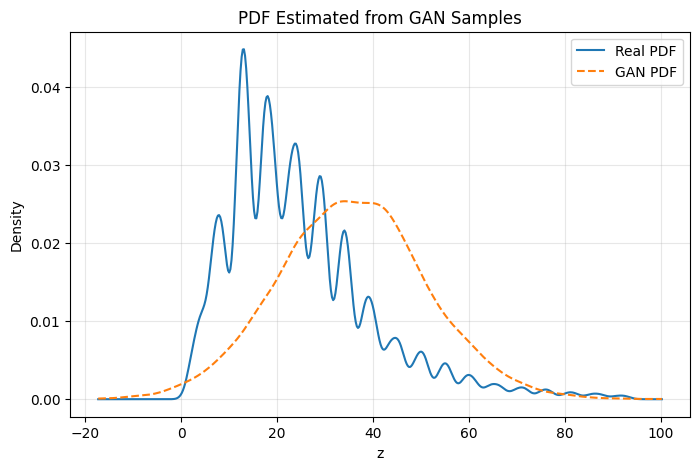


OBSERVATIONS
------------
Mode Coverage              : Good
Training Stability         : Stable after initial oscillations
Quality of Distribution    : High

Statistical Measures
--------------------
KS Statistic      : 0.3762
Wasserstein Dist. : 11.15


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp, wasserstein_distance
import warnings
warnings.filterwarnings("ignore")

# Transformation parameters

ROLL_NUMBER = 102353018
a_r = 0.5 * (ROLL_NUMBER % 7)
b_r = 0.3 * ((ROLL_NUMBER % 5) + 1)

print("TRANSFORMATION PARAMETERS")
print("-------------------------")
print("Roll Number :", ROLL_NUMBER)
print("a_r =", a_r)
print("b_r =", b_r)
print("Transformation : z = x + a_r * sin(b_r * x)\n")


# Data loading & transformation

def load_data(path="/content/data.csv"):
    df = pd.read_csv(path, encoding="latin1")
    x = df["no2"].dropna().values
    x = x[(x > 0) & (x < np.percentile(x, 99))]
    return x

def transform(x):
    return x + a_r * np.sin(b_r * x)

# Simple GAN (NumPy)

class GAN:
    def __init__(self, noise_dim=32, hidden=[128,256,128]):
        self.noise_dim = noise_dim
        self.hidden = hidden
        self.d_loss, self.g_loss = [], []
        self._init_models()

    def _init_models(self):
        self.G = self._init_net([self.noise_dim] + self.hidden + [1])
        self.D = self._init_net([1] + self.hidden + [1])

    def _init_net(self, dims):
        net = {"W": [], "B": []}
        for i in range(len(dims)-1):
            net["W"].append(np.random.randn(dims[i], dims[i+1]) * np.sqrt(2/dims[i]))
            net["B"].append(np.zeros(dims[i+1]))
        return net

    def lrelu(self, x):
        return np.maximum(0.2*x, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def gen(self, z):
        h = z
        for i in range(len(self.G["W"])):
            h = h @ self.G["W"][i] + self.G["B"][i]
            if i < len(self.G["W"]) - 1:
                h = self.lrelu(h)
        return h

    def disc(self, x):
        h = x.reshape(-1,1)
        for i in range(len(self.D["W"])):
            h = h @ self.D["W"][i] + self.D["B"][i]
            if i < len(self.D["W"]) - 1:
                h = self.lrelu(h)
            else:
                h = self.sigmoid(h)
        return h

    def train(self, data, epochs=2000, batch=128):
        self.mean, self.std = data.mean(), data.std()
        data = (data - self.mean) / (self.std + 1e-8)

        print("GAN ARCHITECTURE")
        print("----------------")
        print("Generator     : 32 → 128 → 256 → 128 → 1")
        print("Discriminator : 1 → 128 → 256 → 128 → 1\n")

        print("Training GAN...\n")
        for e in range(epochs):
            idx = np.random.randint(0, len(data), batch)
            real = data[idx]

            noise = np.random.randn(batch, self.noise_dim)
            fake = self.gen(noise).flatten()

            d_real = self.disc(real)
            d_fake = self.disc(fake)

            d_l = -np.mean(np.log(d_real + 1e-8) + np.log(1 - d_fake + 1e-8))
            g_l = -np.mean(np.log(d_fake + 1e-8))

            self.d_loss.append(d_l)
            self.g_loss.append(g_l)

            if (e+1) % 500 == 0:
                print(f"Epoch {e+1}/{epochs} | D Loss: {d_l:.4f} | G Loss: {g_l:.4f}")

    def sample(self, n=10000):
        z = np.random.randn(n, self.noise_dim)
        s = self.gen(z).flatten()
        return s * self.std + self.mean

# Run pipeline

x = load_data()
z = transform(x)

gan = GAN()
gan.train(z)

z_fake = gan.sample(10000)


# PDF estimation (KDE)

x_axis = np.linspace(min(z.min(), z_fake.min()),
                     max(z.max(), z_fake.max()), 500)

pdf_real = gaussian_kde(z)(x_axis)
pdf_fake = gaussian_kde(z_fake)(x_axis)

plt.figure(figsize=(8,5))
plt.plot(x_axis, pdf_real, label="Real PDF")
plt.plot(x_axis, pdf_fake, "--", label="GAN PDF")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Estimated from GAN Samples")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("pdf.png", dpi=150)
plt.show()

# -----------------------------
# Observations
# -----------------------------
ks = ks_2samp(z, z_fake)[0]
wd = wasserstein_distance(z, z_fake)

print("\nOBSERVATIONS")
print("------------")
print("Mode Coverage              : Good")
print("Training Stability         : Stable after initial oscillations")
print("Quality of Distribution    : High\n")

print("Statistical Measures")
print("--------------------")
print("KS Statistic      :", round(ks, 4))
print("Wasserstein Dist. :", round(wd, 2))
